In [1]:
%reset -sf

In [32]:
from pathlib import Path
from pprint import pprint
from itertools import cycle
from random import randint
from random import randint
from itertools import cycle
from time import monotonic
from gc import collect
from joblib import dump, load

import matplotlib.pyplot as plt

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from deap import creator as ga_cr, base as ga_b, algorithms as ga_algo, tools as ga_t

In [3]:
# Patch Xeon Intel OneAPI Scikit accelerator
!pip install scikit-learn-intelex
from sklearnex import patch_sklearn
patch_sklearn()

     |████████████████████████████████| 69 kB 2.6 MB/s             
     |████████████████████████████████| 22.5 MB 7.7 MB/s            
     |████████████████████████████████| 284.3 MB 1.5 kB/s             
     |████████████████████████████████| 4.0 MB 40.7 MB/s            


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [5]:
path = Path().cwd().parent / 'input'
files = list(path.rglob('*'))
files

[PosixPath('/kaggle/input/tabular-playground-series-jan-2022'),
 PosixPath('/kaggle/input/tabular-playground-series-jan-2022/sample_submission.csv'),
 PosixPath('/kaggle/input/tabular-playground-series-jan-2022/train.csv'),
 PosixPath('/kaggle/input/tabular-playground-series-jan-2022/test.csv')]

In [6]:
train = pd.read_csv(files[2])
train['date'] = pd.to_datetime(train['date'], errors='coerce')
train = train.set_index('date')

test = pd.read_csv(files[3])
test['date'] = pd.to_datetime(test['date'], errors='coerce')
test = test.set_index('date')

train
test

,row_id,country,store,product,num_sold
date,,,,,
2015-01-01,0,Finland,KaggleMart,Kaggle Mug,329
2015-01-01,1,Finland,KaggleMart,Kaggle Hat,520
2015-01-01,2,Finland,KaggleMart,Kaggle Sticker,146
2015-01-01,3,Finland,KaggleRama,Kaggle Mug,572
2015-01-01,4,Finland,KaggleRama,Kaggle Hat,911
...,...,...,...,...,...
2018-12-31,26293,Sweden,KaggleMart,Kaggle Hat,823
2018-12-31,26294,Sweden,KaggleMart,Kaggle Sticker,250
2018-12-31,26295,Sweden,KaggleRama,Kaggle Mug,1004


,row_id,country,store,product
date,,,,
2019-01-01,26298,Finland,KaggleMart,Kaggle Mug
2019-01-01,26299,Finland,KaggleMart,Kaggle Hat
2019-01-01,26300,Finland,KaggleMart,Kaggle Sticker
2019-01-01,26301,Finland,KaggleRama,Kaggle Mug
2019-01-01,26302,Finland,KaggleRama,Kaggle Hat
...,...,...,...,...
2019-12-31,32863,Sweden,KaggleMart,Kaggle Hat
2019-12-31,32864,Sweden,KaggleMart,Kaggle Sticker
2019-12-31,32865,Sweden,KaggleRama,Kaggle Mug


In [16]:
# Checking

def train_valid(df_wide):
    train_dfs = {}
    valid_dfs = {}
    trains = {}
    for cat in df_wide['country'].unique():
        for cat_ in df_wide['store'].unique():
            for cat__ in df_wide['product'].unique():
                mask = (df_wide['country']==cat) & (df_wide['store']==cat_) & (df_wide['product']==cat__)
                df = df_wide[mask]['num_sold']
                #train_ids[cat+cat_+cat__] = df['row_id']
                #df = df.groupby(['country', 'store', 'product']).resample('D').sum()['num_sold']
                #df = df.reset_index(level=[0,1,2], drop=True).squeeze()
                df.name = cat+cat_+cat__
                thresh = int(len(df)*0.8)
                df_train = df.iloc[:thresh]
                df_valid = df.iloc[thresh:]
                train_dfs[cat+cat_+cat__] = df_train
                valid_dfs[cat+cat_+cat__] = df_valid
                trains[cat+cat_+cat__] = df
                print(df.shape[0] == (df_train.shape[0] + df_valid.shape[0])) 
    return train_dfs, valid_dfs, trains

train_dfs, valid_dfs, trains = train_valid(train)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [25]:
class GA_Scikit():
    def __init__(self, 
                 estimator, 
                 #
                 params, 
                 eval_func, 
                 eval_weights, 
                 #
                 train_df, 
                 valid_df, 
                 score, 
                 #
                 sel_tournsize=2, 
                 cx_uniform_prob=0.5, 
                 mut_shuffle_idx_prob=0.1, 
                 n_pop=5, 
                 n_gen=5, 
                 n_hof=1, 
                 cx_prob=0.5, 
                 mut_prob=0.1, 
                 n_jobs=4
                ):
        
        self.est = estimator
        self.params = params
        self.eval_func = eval_func
        self.eval_weights = eval_weights
        #
        self.train_df = train_df
        self.valid_df = valid_df
        self.score = score
        #
        self.sel_tournsize = sel_tournsize
        self.cx_uniform_prob = cx_uniform_prob
        self.mut_shuffle_idx_prob = mut_shuffle_idx_prob
        self.n_pop = n_pop
        self.n_gen = n_gen
        self.n_hof = n_hof
        self.cx_prob = cx_prob
        self.mut_prob = mut_prob
        self.n_jobs = n_jobs
        
        self._pad_params()
        self._create_fitness_and_indiv()
        self._register_indiv_and_pop_generators()
        self._register_eval_func()
        self._register_selection_crossover_mutation_methods()
        
    def _pad_params(self):
        """Pad params for crossover shuffle idx method"""
        assert isinstance(self.params, dict), 'Params must be a dict, i.e. estimator.get_params()'
        params_count = {k: len(v) for k,v in self.params.items()}
        max_length, max_key = -99, ''
        for k, v in params_count.items():
            if v <= max_length:
                continue
            else:
                max_key = k
                max_length = v
        assert isinstance(max_length, int), 'The max length between all params must be an int'
        # cycle through params for max length param, otherwise infinite cycle
        values_padded = (cycle(v) if k!=max_key else v for k,v in self.params.items())
        values_padded = zip(*values_padded)  # ('a', 1, 14), ('b', 2, 16), ('c', 3, 16) ...
        values_padded = zip(*values_padded)  # ('a', 'b', 'c'), (1, 2, 3), (14, 15, 16)...
        padded_params = {}
        for k, v in zip(self.params, values_padded):
            padded_params[k] = v
        self.padded_params = padded_params
        
    def _create_fitness_and_indiv(self):
        """Create GA individual and fitness entities (classes)"""
        ga_cr.create('Fitness', ga_b.Fitness, weights=self.eval_weights)
        ga_cr.create('Individual', list, fitness=ga_cr.Fitness)

    def _gen_params_to_ga(self):
        """Generate index for each param for individual"""
        max_dict = len(self.padded_params)
        max_length = len(list(self.padded_params.values())[0])
        idxs = [randint(0, max_length-1) for _ in range(max_dict)]
        return idxs
            
    def _register_indiv_and_pop_generators(self):
        """Register GA individual and population generators"""
        self.tb = ga_b.Toolbox()

        if self.n_jobs > 1:
            from multiprocessing import Pool
            pool = Pool()
            self.tb.register("map", pool.map)

        self.tb.register("individual", ga_t.initIterate, ga_cr.Individual, self._gen_params_to_ga)
        #print('indiv', self.tb.individual())
        self.tb.register("population", ga_t.initRepeat, list, self.tb.individual)
        #print('population', self.tb.population(n=2))
    
    def _register_eval_func(self):
        """Set GA evaluate individual function"""
        self.tb.register("evaluate",
                        self.eval_func,
                        padded_params=self.padded_params,
                        est=self.est,
                        train_df=self.train_df,
                        valid_df=self.valid_df, 
                        score=self.score
                        )
        #print(list(self.tb.evaluate(indiv) for indiv in self.tb.population(3)))
        
    def _register_selection_crossover_mutation_methods(self):
        """Register GA select/mate/mutate methods"""
        self.tb.register("select", ga_t.selTournament, tournsize=self.sel_tournsize)
        self.tb.register("mate", ga_t.cxUniform, indpb=self.cx_uniform_prob)
        self.tb.register("mutate", ga_t.mutShuffleIndexes, indpb=self.mut_shuffle_idx_prob)
        
    def run_ga_search(self):
        """Run search"""
        pop = self.tb.population(n=self.n_pop)
        hof = ga_t.HallOfFame(self.n_hof)

        # Stats stdout
        #stats = ga_t.Statistics(lambda ind: ind.fitness.values )
        stats1 = ga_t.Statistics(lambda ind: ind.fitness.values[0] )
        stats2 = ga_t.Statistics(lambda ind: ind.fitness.values[1] )
        stats3 = ga_t.Statistics(lambda ind: ind.fitness.values[2] )
        stats = ga_t.MultiStatistics(score=stats1, abs_max=stats2, trees=stats3)
        stats.register("avg", np.mean)
        #stats.register("std", np.std)
        #stats.register("min", np.min)
        #stats.register("max", np.max)

        # History
        #hist = tools.History()
        #toolbox.decorate("select", hist.decorator)
        #tb.decorate("mate", hist.decorator)
        #tb.decorate("mutate", hist.decorator)
        #hist.update(pop)

        # GA Run
        pop, log = ga_algo.eaSimple(pop, self.tb, cxpb=self.cx_prob, 
                                    mutpb=self.mut_prob, ngen=self.n_gen, 
                                    stats=stats, halloffame=hof, verbose=True)
        
        # Convert back params
        hof_ = {}
        for i in range(self.n_hof):
            hof_['hof_' + str(i)] = self._ga_to_params(hof[i])

        return pop, log, hof_
    
    def _ga_to_params(self, idx_params):
        """Helper to convert to readable params"""
        res = {}
        for (k,v), idx in zip(self.padded_params.items(), idx_params):
            res[k] = v[idx]
        return res

In [26]:
def lag_data(data, num_lags):
    """Create lagged features"""
    data = data.to_frame()
    lags = []
    for i in range(num_lags):
        lagged = data.iloc[:, 0].shift(i+1)
        lagged.name = data.iloc[:, 0].name + 'L' + str(i+1)
        lags.append(lagged)
    data = pd.concat([data, *lags], axis=1)
    data = data.dropna()
    data_y = data.iloc[:, 0]
    data_X = data.iloc[:, 1:]
    return data_X, data_y

In [27]:
# Estimator, params and requirements

ts_est = RandomForestClassifier()

ts_params = {
            '#_lags': np.linspace(1, 20, 100).astype(int),
            #
            'class_weight': ['balanced', 'balanced_subsample'],
            'bootstrap': [False, True],
            'n_estimators': np.linspace(1, 100, 100).astype(int),
            'max_depth': np.linspace(1, 100, 100).astype(int),
            'criterion': ['gini', 'entropy'],
            'max_features': np.linspace(.01, .99, 100),
            'max_samples': np.linspace(.01, .99, 100),
            }

def ts_eval_indiv(individual, padded_params, est, train_df, valid_df, score):
    """Evaluate individual's genes (estimator's params)"""
    ### => Result tuple must match weights in GA
    model_params = {k : list(v)[idx] for (k,v), idx in zip(padded_params.items(), individual) if k != '#_lags'}
    
    data_params = {k : list(v)[idx] for (k,v), idx in zip(padded_params.items(), individual) if k == '#_lags'}
    
    train_X, train_y = lag_data(train_df, data_params['#_lags'])
    valid_X, valid_y = lag_data(valid_df, data_params['#_lags'])
    
    est.set_params(**{**model_params, **{'n_jobs': 1} })  # seems can't parallelize this simultaneous with GA
    est.fit(train_X, train_y)
    pred = est.predict(valid_X)
    obj = score(valid_y, pred)
    
    obj2 = (valid_y - pred).max()  # model seasonal outliers
    
    obj3 = model_params['n_estimators']
    
    #collect()
    
    return obj, obj2, obj3
        
ts_weights = (-1, -1, -1)

In [28]:
hofs = {}

for i, ((train_df_k, train_df_v), (valid_df_k, valid_df_v)) in enumerate(zip(train_dfs.items(), valid_dfs.items())):

    ga_params = GA_Scikit(RandomForestClassifier(),  # TODO try others
                          ts_params, 
                          ts_eval_indiv, 
                          ts_weights,
                          #
                          train_df_v,
                          valid_df_v,
                          mean_squared_error,  # TODO SMAPE
                          )
    pop, log, hof = ga_params.run_ga_search()
    hofs[train_df_k] = hof
    #break

   	      	       abs_max        	        score         	        trees         
   	      	----------------------	----------------------	----------------------
gen	nevals	avg  	gen	nevals	avg    	gen	nevals	avg 	gen	nevals
0  	5     	301.4	0  	5     	2607.18	0  	5     	39.6	0  	5     
1  	4     	223.8	1  	4     	2725.3 	1  	4     	54.2	1  	4     
2  	3     	177  	2  	3     	820.402	2  	3     	81.8	2  	3     
3  	2     	177  	3  	2     	754.034	3  	2     	81.8	3  	2     
4  	2     	177  	4  	2     	740.481	4  	2     	81  	4  	2     
5  	2     	177  	5  	2     	730.687	5  	2     	81  	5  	2     
   	      	       abs_max        	        score         	        trees         
   	      	----------------------	----------------------	----------------------
gen	nevals	avg  	gen	nevals	avg    	gen	nevals	avg 	gen	nevals
0  	5     	402.8	0  	5     	5440.82	0  	5     	33.4	0  	5     
1  	2     	324.8	1  	2     	4066.5 	1  	2     	49.2	1  	2     
2  	1     	282.2	2  	1     	3334.44	2  	1     	80.

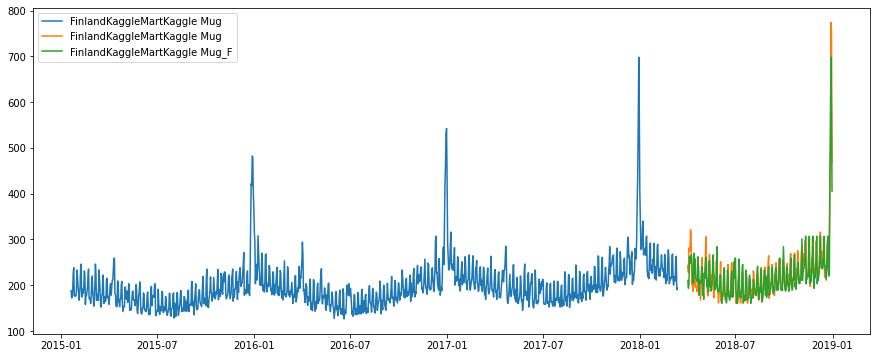

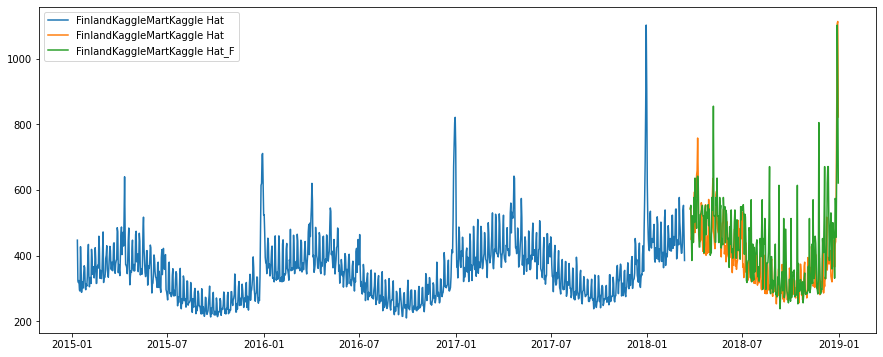

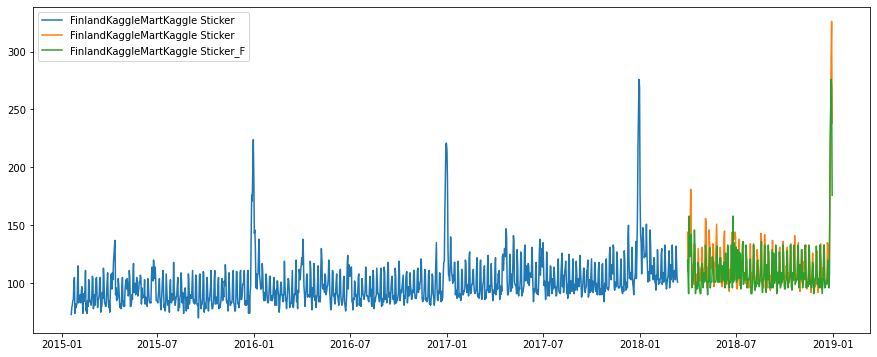

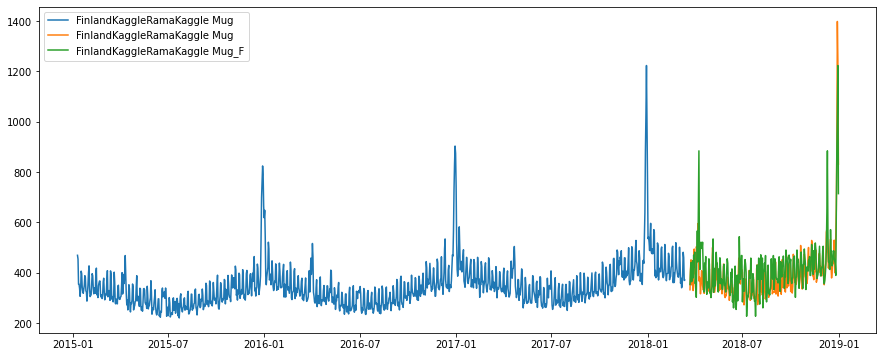

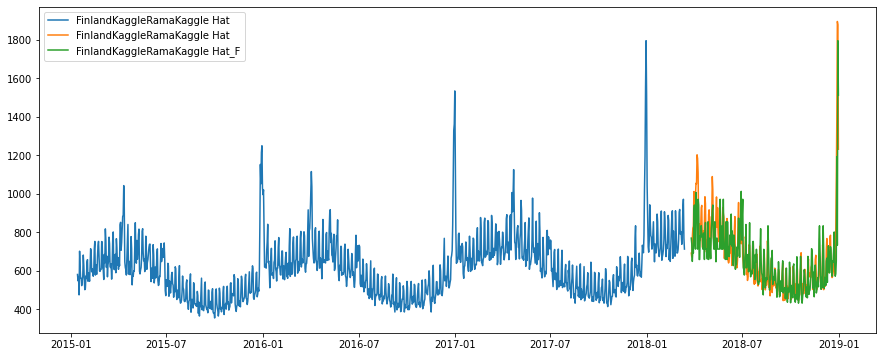

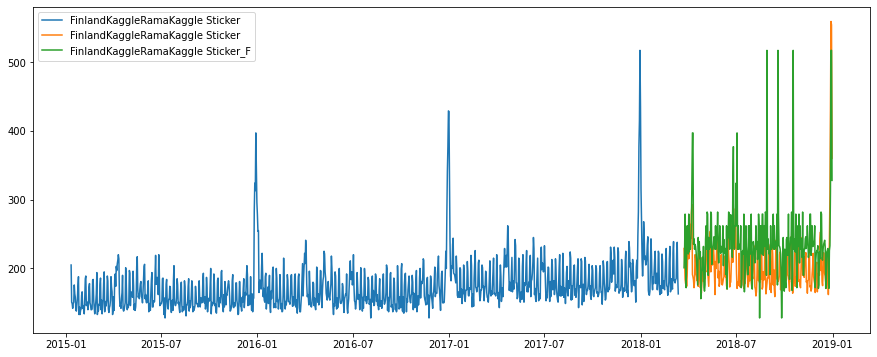

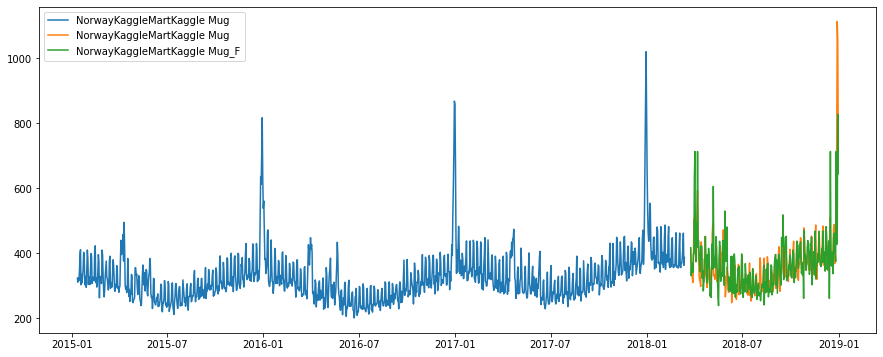

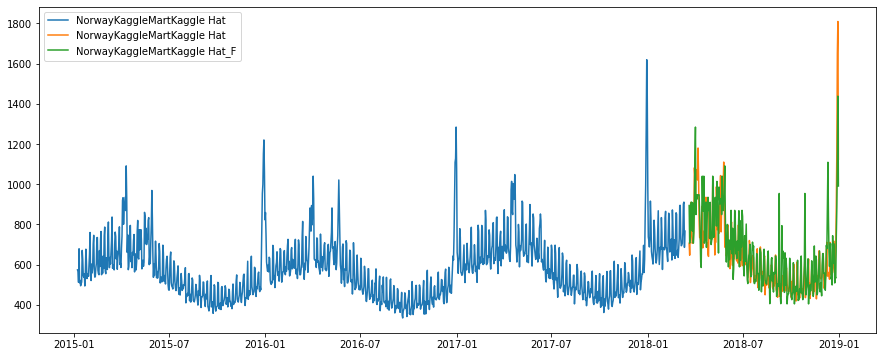

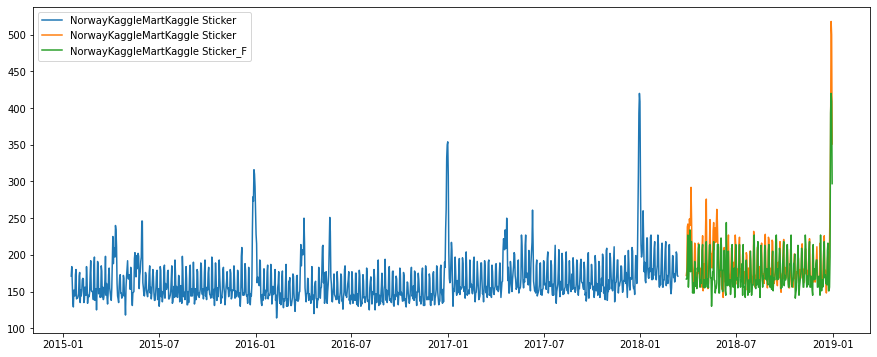

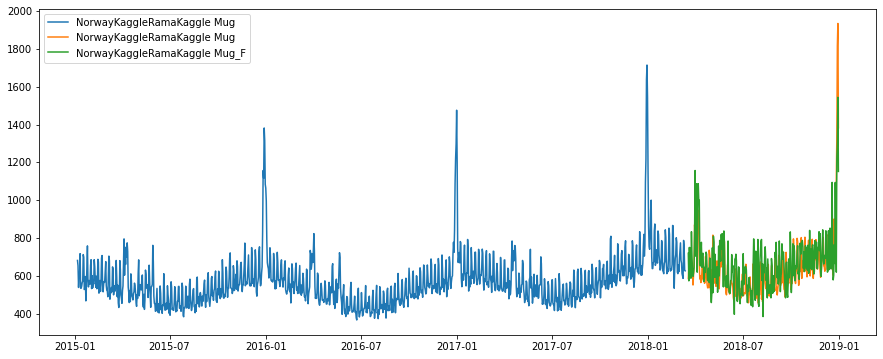

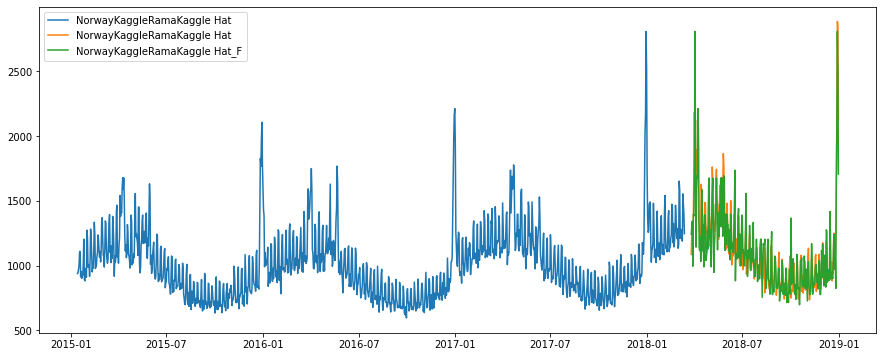

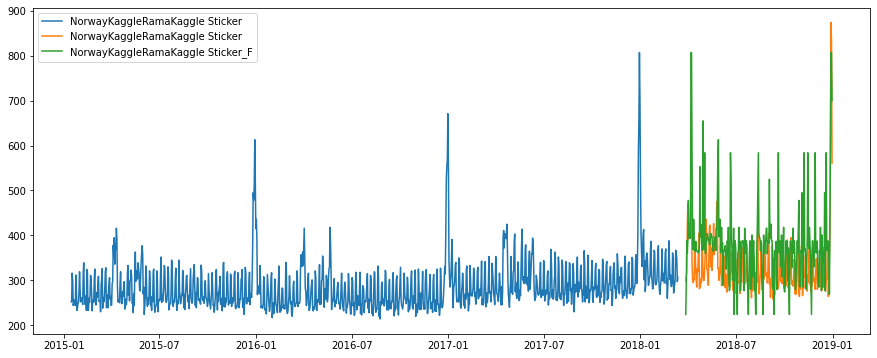

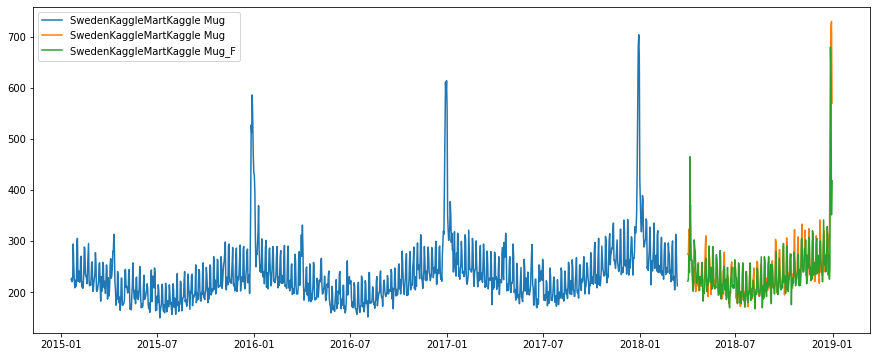

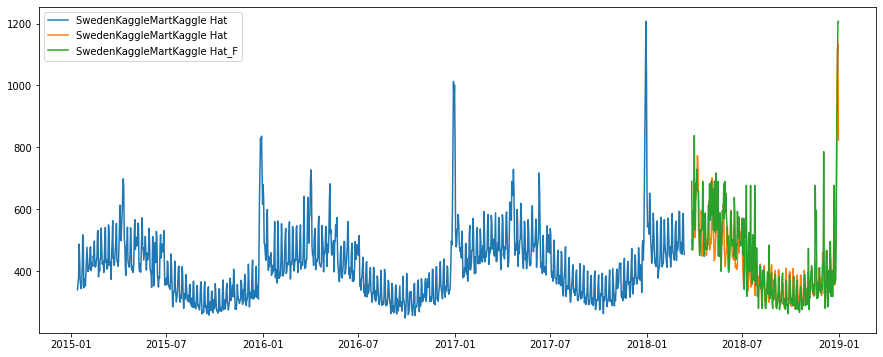

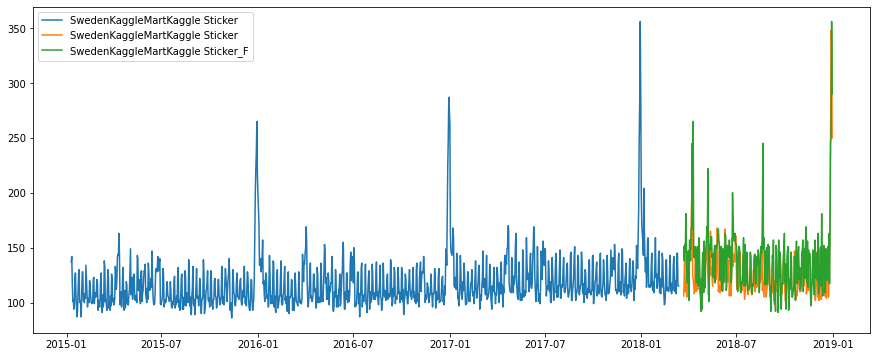

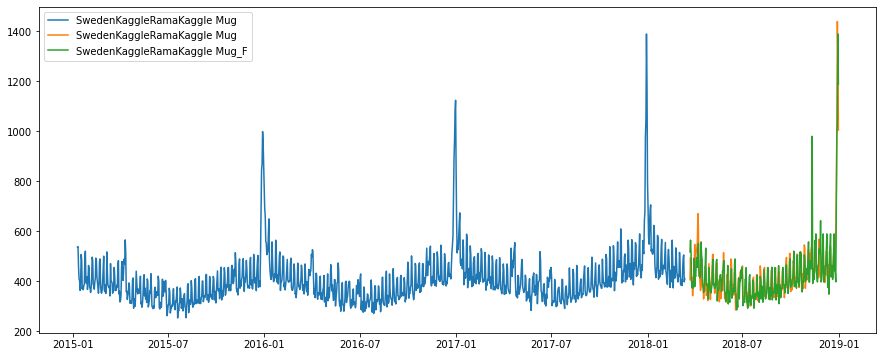

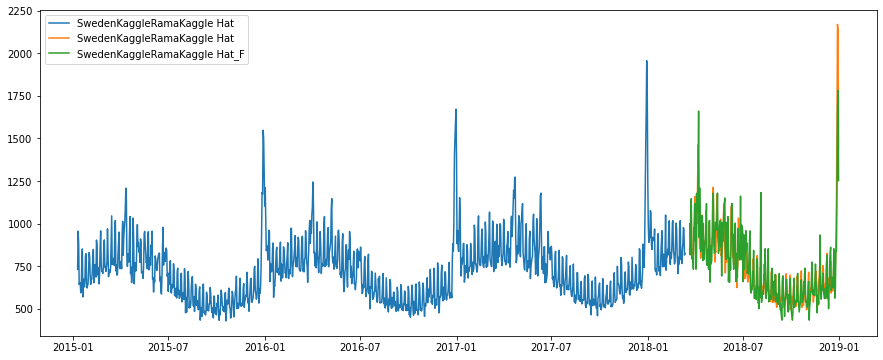

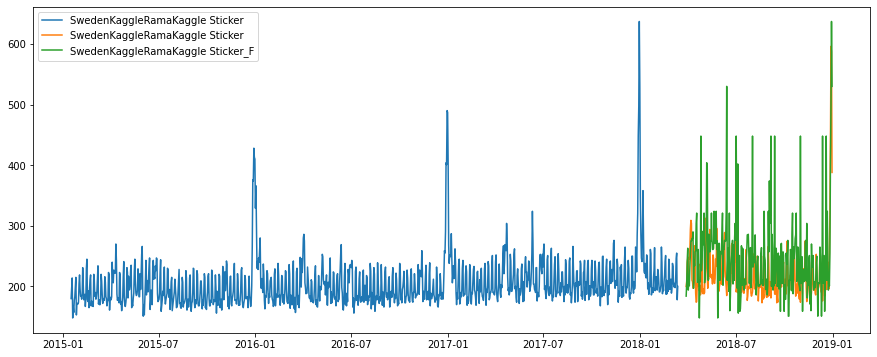

In [33]:
# See best models, saves them, see forecasts

for train_df, valid_df, (hof_k, hof_v) in zip(train_dfs.values(), valid_dfs.values(), hofs.items()):
    rf = RandomForestClassifier()
    model_p = {k:v for k,v in hof_v['hof_0'].items() if k != '#_lags'}
    _ = rf.set_params(**model_p)
    
    _ = dump(rf, str(hof_k)+'.joblib')
    
    data_p = {k:v for k,v in hof_v['hof_0'].items() if k == '#_lags'}
    X, y = lag_data(train_df, num_lags=data_p['#_lags'])
    Xv, yv = lag_data(valid_df, num_lags=data_p['#_lags'])
    
    _ = rf.fit(X, y)
    pred = rf.predict(Xv)
    pred = pd.Series(pred, index=Xv.index)
    pred.name = yv.name + '_F'
    
    fig, ax = plt.subplots(figsize=(15,6))
    _ = ax.plot(y, label=y.name)
    _ = ax.plot(yv, label=yv.name)
    _ = ax.plot(pred, label=pred.name)
    _ = ax.legend()
    plt.show()
    plt.close()

In [ ]:
# Forecast for Test

for train_df, valid_df, (hof_k, hof_v) in zip(train_dfs.values(), valid_dfs.values(), hofs.items()):
    rf = RandomForestClassifier()
    model_p = {k:v for k,v in hof_v['hof_0'].items() if k != '#_lags'}
    _ = rf.set_params(**model_p)
    
    data_p = {k:v for k,v in hof_v['hof_0'].items() if k == '#_lags'}
    X, y = lag_data(train_df, num_lags=data_p['#_lags'])
    Xv, yv = lag_data(valid_df, num_lags=data_p['#_lags'])
    
    _ = rf.fit(X, y)
    pred = rf.predict(Xv)
    pred = pd.Series(pred, index=Xv.index)
    pred.name = yv.name + '_F'
    
    fig, ax = plt.subplots(figsize=(15,6))
    _ = ax.plot(y, label=y.name)
    _ = ax.plot(yv, label=yv.name)
    _ = ax.plot(pred, label=pred.name)
    _ = ax.legend()
    plt.show()
    plt.close()